<a href="https://colab.research.google.com/github/lkkcpaul/BostonHousePrice/blob/main/BostonHousePriceRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and preprocess data

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
train_file_url = "https://raw.githubusercontent.com/lkkcpaul/BostonHousePrice/main/train.csv"
dataset_df = pd.read_csv(train_file_url)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [3]:
dataset_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

What to do with null objects? There are a few with many nulls.

Alley: NA in alley means no alley access, which contains information

FireplaceQu: NA means no fireplace, which is encoded in "Fireplaces"

PoolQC: NA means no pool. That only 7 houses have pools, we probably don't need to distinguish between the quality of the pools

Fence: NA means no fence

MiscFeature: 49 of them are Shed. So we probably just make a column of "Shed" and delete this one

In [3]:
# Find the numeric columns that have missing values
# Decide how to fill them
has_numeric_na = dataset_df.select_dtypes(include=np.number).isna().any()
has_numeric_na[has_numeric_na]

LotFrontage    True
MasVnrArea     True
GarageYrBlt    True
dtype: bool

In [ ]:
# We will impute Lot Frontage with mean,
# MasVnrArea with 0
# And GarageYrBlt with majority (since missing values just mean there's no garage)

In [4]:
drop_col = ['Id','PoolArea', 'PoolQC']
fillna_dict = {'MasVnrArea':0, 
               'LotFrontage':dataset_df.LotFrontage.mean(),
               'GarageYrBlt':dataset_df.GarageYrBlt.mean()
             }

def preprocess(data):
  temp = data.drop(drop_col, axis=1)
  temp['Shed']=0
  temp['Shed'][temp['MiscFeature']=='Shed'] = 1
  temp.drop('MiscFeature',axis=1,inplace=True)
  temp.fillna(fillna_dict,inplace=True)
  return temp

In [5]:
df = preprocess(dataset_df)

<ipython-input-4-e924caf0fb0a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Shed'][temp['MiscFeature']=='Shed'] = 1


In [6]:
from sklearn.preprocessing import OneHotEncoder
X_w_cat = df.drop('SalePrice',axis=1)
X_w_cat['MSSubClass'] = X_w_cat['MSSubClass'].map(str)
y = df.SalePrice
OHE = OneHotEncoder(handle_unknown = 'ignore',sparse_output=False)
X = pd.DataFrame(OHE.fit_transform(X_w_cat))

Text(0, 0.5, 'Frequency')

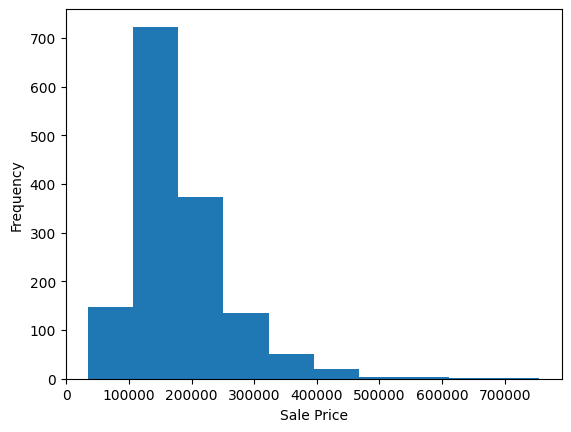

In [10]:
plt.hist(y)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')

# Linear Regression as benchmark

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_test_rmse = np.sqrt(mean_squared_error(y_test,lr.predict(X_test)))
print('The RMSE using linear regression is:', lr_test_rmse )

The RMSE using linear regression is: 31353.85868759527


# Random Forest

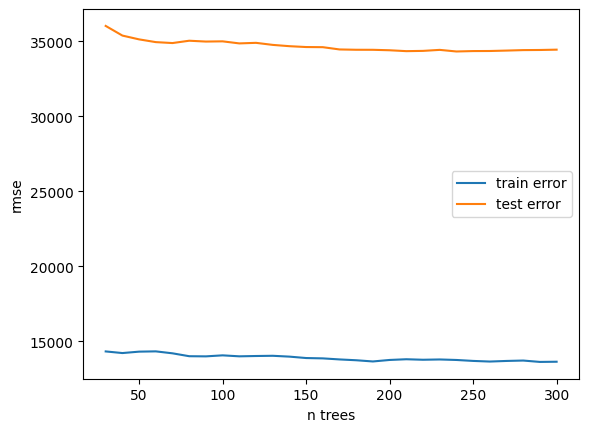

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

MIN_ESTIMATOR = 30
MAX_ESTIMATOR = 300

rf = RandomForestRegressor(
    warm_start=True,
    random_state=8)

train_error = []
test_error = []

for n_estimators in range(MIN_ESTIMATOR, MAX_ESTIMATOR+1, 10):
  rf.set_params(n_estimators=n_estimators)
  rf.fit(X_train,y_train)
  train_rmse = math.sqrt(mean_squared_error(y_train,rf.predict(X_train)))
  test_rmse = math.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
  
  train_error.append((n_estimators,train_rmse))
  test_error.append((n_estimators,test_rmse))
  
xs, ys = zip(*train_error)
plt.plot(xs,ys,label='train error')
xs, ys = zip(*test_error)
plt.plot(xs,ys,label='test error')
plt.xlabel('n trees')
plt.ylabel('rmse')
plt.legend()
plt.show()

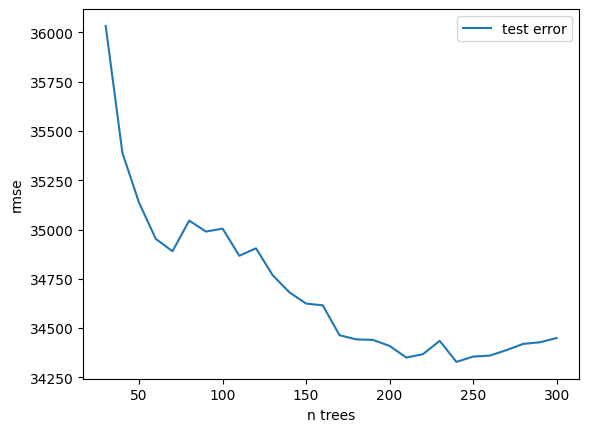

In [ ]:
xs, ys = zip(*test_error)
plt.plot(xs,ys,label='test error')
plt.xlabel('n trees')
plt.ylabel('rmse')
plt.legend()
plt.show()

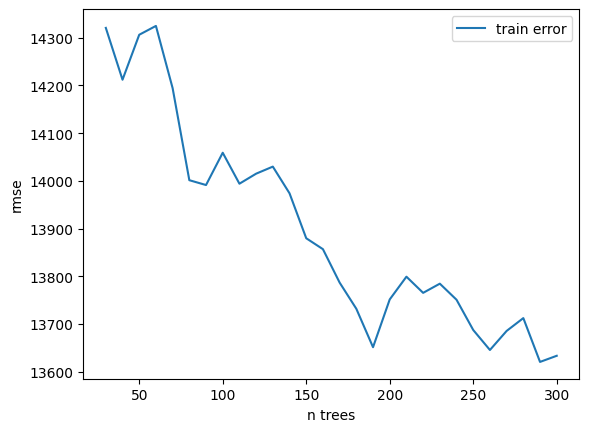

In [ ]:
xs, ys = zip(*train_error)
plt.plot(xs,ys,label='train error')
plt.xlabel('n trees')
plt.ylabel('rmse')
plt.legend()
plt.show()

# XGBoost

First try to drive the training loss to 0

In [ ]:
from xgboost.sklearn import XGBRegressor

In [16]:
%%time
xgb = XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=15)
xgb.fit(X_train,y_train)
print('The train rmse is:',
      np.sqrt(mean_squared_error(y_train,xgb.predict(X_train)))
)
print('The test rmse is:',
      np.sqrt(mean_squared_error(y_test,xgb.predict(X_test)))
)

The train rmse is: 931.5046109452572
The test rmse is: 35326.417209245716
CPU times: user 1min 52s, sys: 259 ms, total: 1min 52s
Wall time: 1min 7s


In [17]:
from sklearn.model_selection import RandomizedSearchCV
xgb_params = {
    'max_depth':range(4,16),
    #'gamma':[0.01,0.1,1,10],
    'learning_rate':[0.001,0.01,0.03,0.1],
    'n_estimators':[50,75,100,125,150]
}
n_trials = 10

xgb = XGBRegressor()
xgb_rscv = RandomizedSearchCV(xgb, 
                              xgb_params, 
                              n_iter = n_trials, 
                              scoring='neg_mean_squared_error',
                              verbose=3, cv=3)
xgb_rscv.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=-32938452339.709 total time=  23.8s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=-32905350825.447 total time=  23.1s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=-31430476980.259 total time=  22.7s
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=75;, score=-10222025678.241 total time=  29.6s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=75;, score=-10711986956.303 total time=  27.8s
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=75;, score=-9732184617.352 total time=  30.2s
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=150;, score=-1406492415.983 total time=  44.5s
[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=150;, score=-1383211648.357 total time=  44.0s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=150;, score=-1257828825.301

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.03,
                                                          0.1],
                                        'max_depth': range(4, 16),
                                        'n_estimators': [50, 75, 100, 125,
                                                         150]},
                   scoring='neg_mean_squared_error', verbose=3)

In [20]:
print('The best xgb has parameters:', xgb_rscv.best_params_)

The best xgb has parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}


In [21]:
print('with rmse square', np.sqrt(abs(xgb_rscv.best_score_)))

with rmse square 34997.44706047258


In [3]:
import lightgbm